In [4]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import io
import itertools
import gradio as gr
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

In [6]:
# %%
# Load the dataset
df = pd.read_csv("data/Top_12_German_Companies_Financial_Data.csv")
companies = np.unique(df.Company)
company = companies[9]
print(f"Company: {company}")

# Filter for selected company
df = df[df["Company"] == company].copy()
df["Period"] = pd.to_datetime(df["Period"], format="%m/%d/%Y")
df = df.sort_values(by="Period")
df.set_index("Period", inplace=True)
df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")

# Ensure no missing values
df = df.fillna(method="ffill")

Company: SAP SE


In [7]:
# %%
# Convert time series to supervised learning format
def create_features_targets(series, n_lags=4, n_outputs=4):
    """
    Convert time series into supervised learning format.
    - n_lags: Number of past time steps to use as input
    - n_outputs: Number of future time steps to predict
    """
    X, y = [], []
    
    for i in range(len(series) - n_lags - n_outputs):
        X.append(series[i : i + n_lags])
        y.append(series[i + n_lags : i + n_lags + n_outputs])
    
    return np.array(X), np.array(y)

# Define number of past quarters to use as features and number of quarters to predict
n_lags = 4
n_outputs = 4  # Forecast 4 quarters ahead

# Prepare data
series = df['Revenue'].values
X, y = create_features_targets(series, n_lags, n_outputs)


In [ ]:
# Train-validation-test split
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.9)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

# %%
# Train Multi-Output XGBoost Model
base_model = lgb.LGBMRegressor(objective="regression", n_estimators=1000, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

# Validate Model
y_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MAE: {val_mae:.2f}")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 19, number of used features: 0
[LightGBM] [Info] Start training from score 11924150164.210526
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will b

In [9]:
# %%
# Function to forecast future revenue
def forecast_turnover(horizon):
    """
    Forecast revenue for the next `horizon` quarters using Multi-Output XGBoost.
    """
    try:
        horizon = int(horizon)
        assert horizon >= 4, "❌ Forecasting requires at least 4 quarters."

        # Use the last `n_lags` values as input for prediction
        last_inputs = series[-n_lags:].reshape(1, -1)
        predictions = model.predict(last_inputs).flatten()[:horizon]  # Take only required quarters

        # Generate future dates
        last_date = df.index[-1]
        future_dates = pd.date_range(start=last_date, periods=horizon + 1, freq="Q")[1:]

        debug_info = f"""
        ✅ Forecast for {horizon} quarters.
        Last Date in Training Data: {last_date}
        Future Dates: {future_dates}
        Forecasted Values: {predictions}
        """

        # Plot results
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df.index, df["Revenue"], label="Actual Revenue", color="blue")
        ax.plot(future_dates, predictions, label="XGBoost Forecast", linestyle="dashed", marker="x", color="red")
        ax.set_xlabel("Year")
        ax.set_ylabel("Revenue")
        ax.set_title(f"XGBoost Multi-Output Forecast for {company} Revenue")
        ax.legend()

        # Convert Matplotlib plot to NumPy array
        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format="PNG")
        plt.close(fig)
        img_buffer.seek(0)

        img_pil = PIL.Image.open(img_buffer)
        img_np = np.array(img_pil)  # Convert PIL Image to NumPy array

        return img_np, debug_info

    except Exception as e:
        return None, f"❌ Error: {str(e)}"

/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



        ✅ Forecast for 4 quarters.
        Last Date in Training Data: 2024-12-31 00:00:00
        Future Dates: DatetimeIndex(['2025-03-31', '2025-06-30', '2025-09-30', '2025-12-31'], dtype='datetime64[ns]', freq='Q-DEC')
        Forecasted Values: [1.19241502e+10 1.17678784e+10 1.22533050e+10 1.23939801e+10]
        


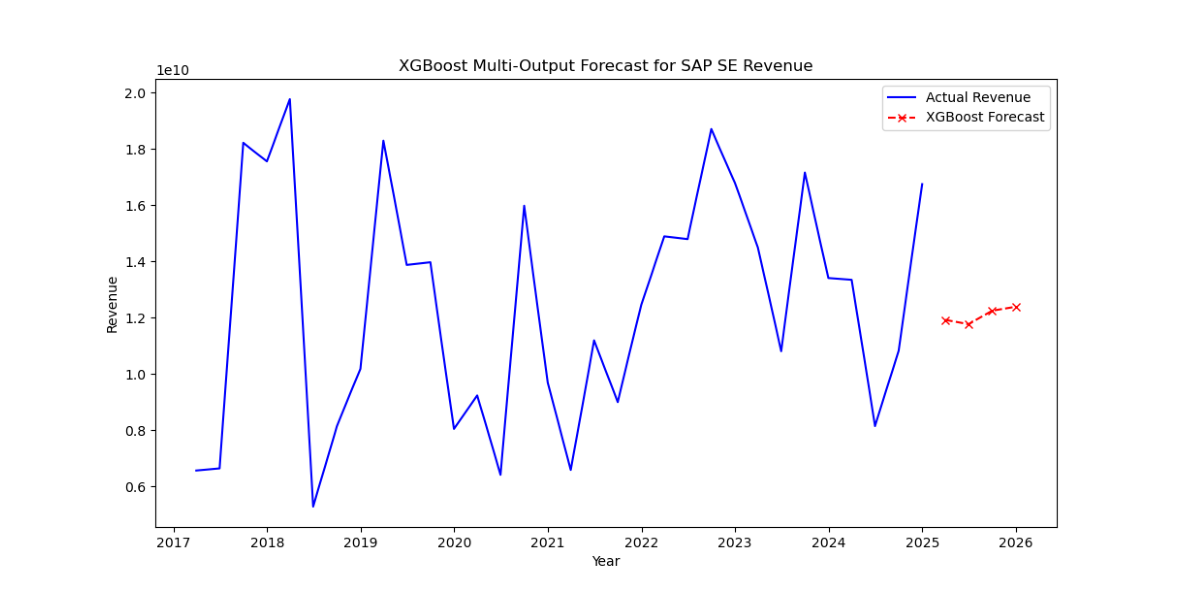

In [10]:
# %%
# Test forecast function
image, debug_message = forecast_turnover(horizon=4)
print(debug_message)

if image is not None:
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    plt.close()
